# Применение Oracle Data Science Python Notebooks для создания Function.

#### Загрузка необходимых библиотек

In [16]:
import pandas as pd

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
from ads.catalog.project import ProjectCatalog

import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Загрузка данных

In [17]:
compartment_id = os.environ["NB_SESSION_COMPARTMENT_OCID"]
project_id = os.environ["PROJECT_COMPARTMENT_OCID"]

In [2]:
data_source = 'diabetes.csv'
ds = DatasetFactory.open(data_source)
ds.head()

HTML(value='\n        <style>\n            .mostly-customized-scrollbar {\n              display: block;\n    …

5 rows, 9 columns

#### Что будем предсказывать ?

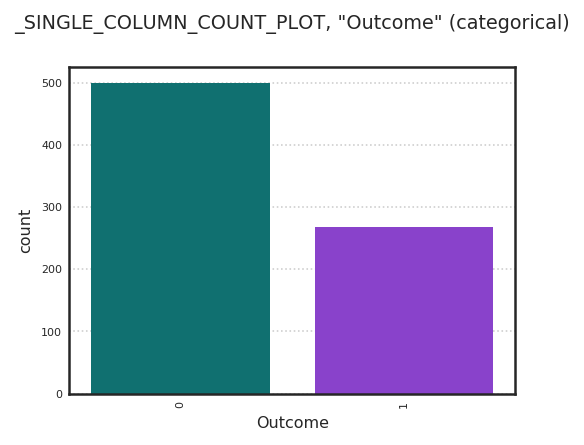

In [3]:
ds.plot("Outcome")

#### Определим целевую переменную

In [4]:
ds = ds.set_target("Outcome")

#### Изучим исходные данные

In [5]:
ds.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>768 Rows, 9 Columns</h3><h4>Colu…

#### Разделяем данные для обучения и тестовые наборы данных

In [6]:
train, test = ds.train_test_split()

#### Инициализируем AutoML 

In [7]:
ml_engine = OracleAutoMLProvider()
automl = AutoML(train, provider=ml_engine)
model, baseline = automl.train(model_list=['LGBMClassifier',
                                          'XGBClassifier',
                                          'RandomForestClassifier'],
                               score_metric="roc_auc",
                               time_budget=120)

Training Dataset size,"(687, 8)"
Validation Dataset size,None
CV,5
Target variable,Outcome
Optimization Metric,roc_auc
Initial number of Features,8
Selected number of Features,7
Selected Features,"[Pregnancies, Glucose, BloodPressure, Insulin, BMI, DiabetesPedigreeFunction, Age]"
Selected Algorithm,XGBClassifier
End-to-end Elapsed Time (seconds),642.6
Selected Hyperparameters,"{'booster': 'gbtree', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
2,XGBClassifier_AdaBoostClassifier_FS,687,7,0.8381,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",24.5027
3,XGBClassifier_RandomForestClassifier_FS,687,6,0.8367,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",36.2094
4,XGBClassifier_AVGRanking_FS,687,5,0.8359,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",10.1483
5,XGBClassifier_RandomForestClassifier_FS,687,4,0.8354,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",22.4115
6,XGBClassifier_ADS,548,8,0.8347,"{'n_estimators': 100, 'learning_rate': 0.1, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'class_weight': 'balanced', 'booster': 'gbtree', 'random_state': 7, 'n_jobs': 2}",24.6177
...,...,...,...,...,...,...
26,XGBClassifier_ANOVAF_FS,687,2,0.7984,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",12.0067
27,XGBClassifier_MutualInfo_FS,687,2,0.7962,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",31.3081
28,XGBClassifier_AdaBoostClassifier_FS,687,2,0.7898,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",35.7555
29,XGBClassifier_ANOVAF_FS,687,1,0.7643,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",2.0953


#### Результаты работы алгоритмов

#### Выбранный алгоритм отмечен оранжевым цветом, так как набрал наибольший счет (predicted score) .

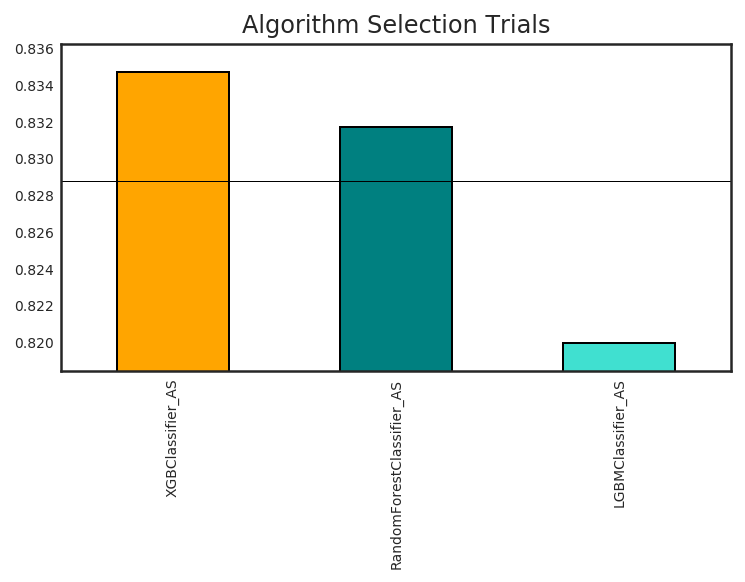

In [8]:
automl.visualize_algorithm_selection_trials()

#### Оценка модели

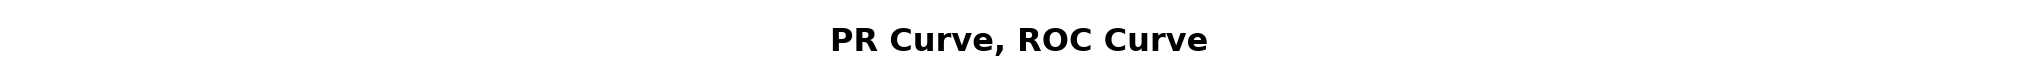

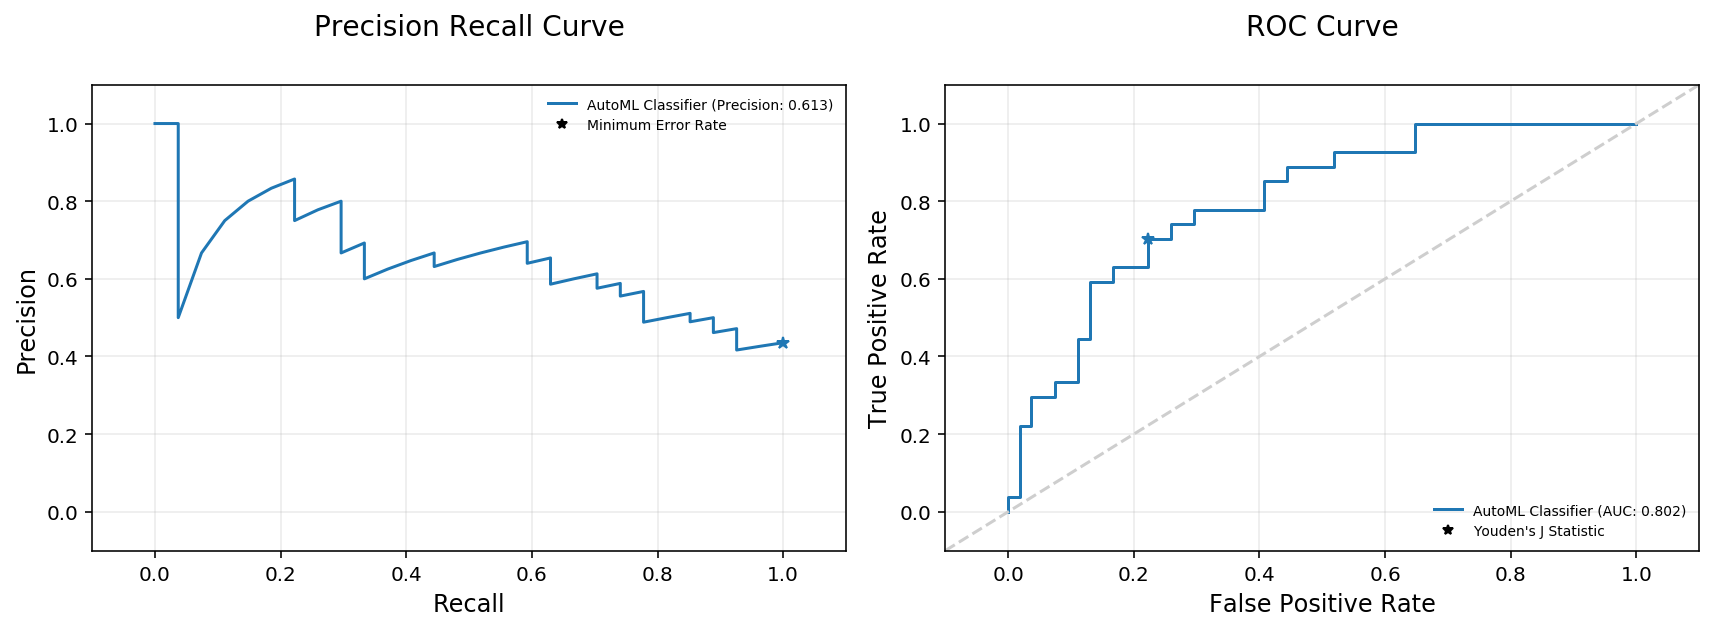

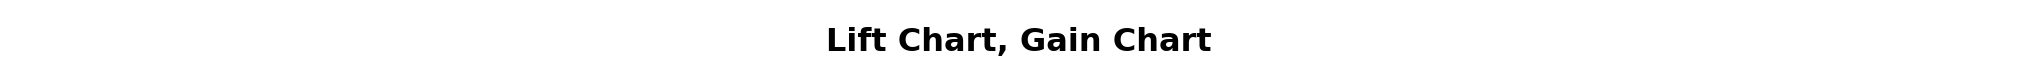

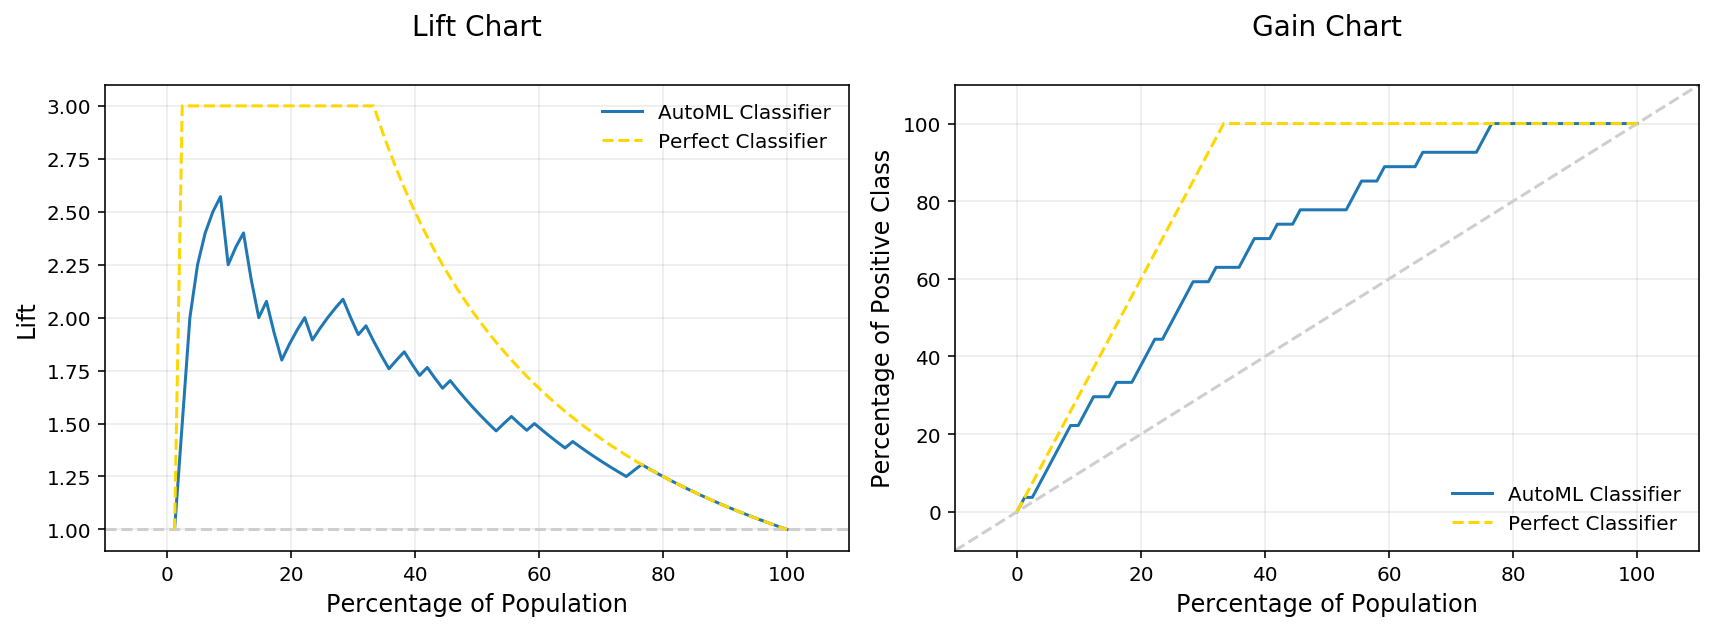

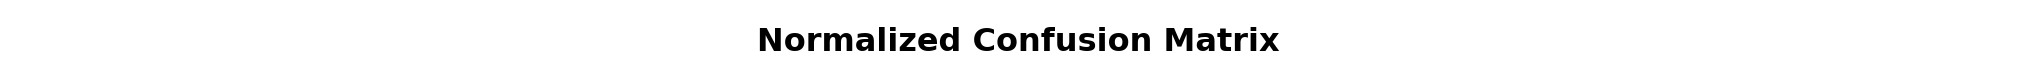

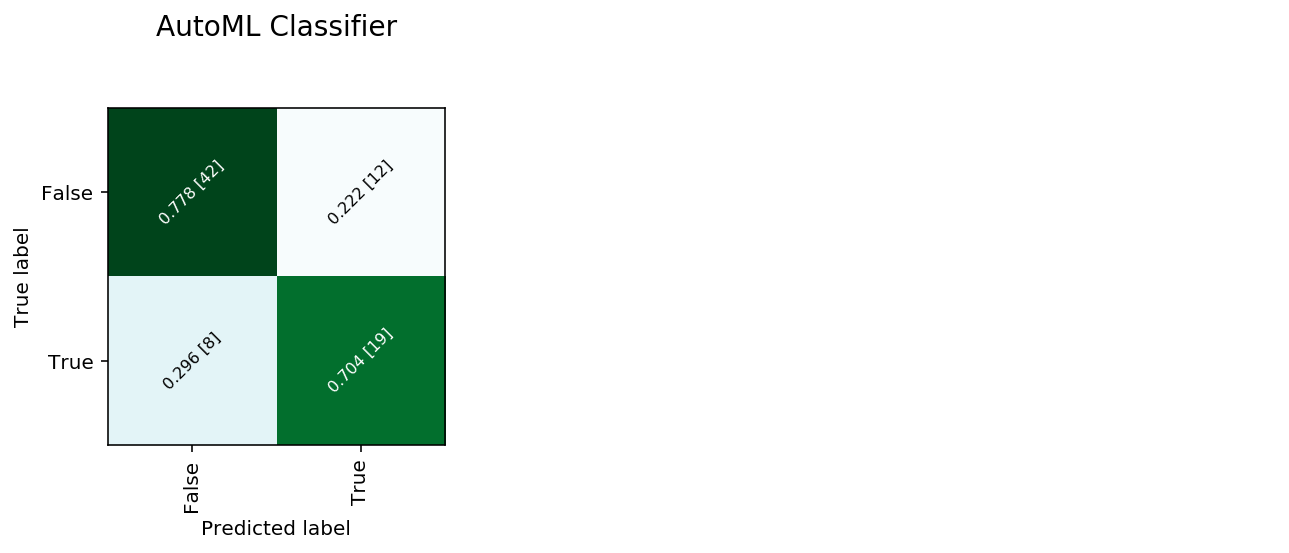

In [9]:
evaluator = ADSEvaluator(test, models=[model], training_data=train)
evaluator.show_in_notebook(perfect=True)

#### Оцениваем важность

In [10]:
explainer = ADSExplainer(test, model)
global_explainer = explainer.global_explanation(provider=MLXGlobalExplainer())
importances = global_explainer.compute_feature_importance()

In [11]:
importances.show_in_notebook(n_features=5)

#### Локальные предположения

In [12]:
(x, y) = test.X.iloc[23:24], test.y.iloc[23:24]
explainer.local_explanation(provider=MLXLocalExplainer()).explain(x, y).show_in_notebook()

#### Предсказываем на оригинальных данных

In [13]:
X = ds.sampled_df
y_true = ds.sampled_df["Outcome"]
print("Accurancy:", model.score(X, y_true))

Accurancy: 0.9436082089552239


#### Сохраняем модель

In [14]:
model_artifact = model.prepare("tmp/model/", force_overwrite=True)
model_artifact2 = baseline.prepare("tmp/model2/", force_overwrite=True)

Generated model artifact files under tmp/model/.


Generated model artifact files under tmp/model2/.
